# CAISO Energy Storage Bid Analysis

<b>Author:</b> Neal Ma

<b>Date Created:</b> October 1, 2024

<b>Description:</b> This notebook analyzes CAISO Energy Storage bid data obtained from CAISO Daily Energy Storage Reports.

CAISO Average Price Data from LCG Consulting (http://www.energyonline.com/Data/GenericData.aspx?DataId=20)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates

In [42]:
data_path = "./data/ES_BIDS/"
df = pd.read_parquet(data_path + "CAISO_ES_BIDS.parquet")

caiso_avg_price_df = pd.read_csv("./data/CAISOAvgPrice.csv")
caiso_avg_price_df["date"] = pd.to_datetime(caiso_avg_price_df["date"])
caiso_avg_price_df.set_index("date", inplace=True)
df = df.merge(caiso_avg_price_df, left_index=True, right_index=True, how="left")

C:\Users\Astro\AppData\Local\Temp\ipykernel_29960\1395203911.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  caiso_avg_price_df['date'] = pd.to_datetime(caiso_avg_price_df['date'])


In [27]:
bid_cols = [col for col in df.columns if "bid" in col]

bid_segments = {
    "ss": "Self Schedule",
    "1": "[-150, -100]",
    "2": "(-100, -50]",
    "3": "(-50, -15]",
    "4": "(-15, 0]",
    "5": "(0, 15]",
    "6": "(15, 50]",
    "7": "(50, 100]",
    "8": "(100, 200]",
    "9": "(200, 500]",
    "10": "(500, 1000]",
    "11": "(1000, 2000]",
}

In [16]:
y_1_date_range = [pd.Timestamp("2022-07-01"), pd.Timestamp("2023-07-01")]
y_2_date_range = [pd.Timestamp("2023-07-01"), pd.Timestamp("2024-07-01")]

y_1_df = df.loc[(df.index >= y_1_date_range[0]) & (df.index < y_1_date_range[1])]
y_2_df = df.loc[(df.index >= y_2_date_range[0]) & (df.index < y_2_date_range[1])]

In [17]:
AGGREGATION_GRANULARITY = "D"

# plot the capacity-normalized bids for every segment aggregated daily
bid_columns = [col for col in df.columns if "bid" in col]

# aggregate daily capacities (time-based average) from df
df_daily_aggregate = df[bid_columns].resample(AGGREGATION_GRANULARITY).mean()
df_daily_aggregate["bid_rtpd_neg_tot"] = sum(
    [df_daily_aggregate[col_name] for col_name in bid_columns if "rtpd_neg" in col_name]
)
df_daily_aggregate["bid_rtpd_pos_tot"] = sum(
    [df_daily_aggregate[col_name] for col_name in bid_columns if "rtpd_pos" in col_name]
)
df_daily_aggregate["bid_ifm_neg_tot"] = sum(
    [df_daily_aggregate[col_name] for col_name in bid_columns if "ifm_neg" in col_name]
)
df_daily_aggregate["bid_ifm_pos_tot"] = sum(
    [df_daily_aggregate[col_name] for col_name in bid_columns if "ifm_pos" in col_name]
)

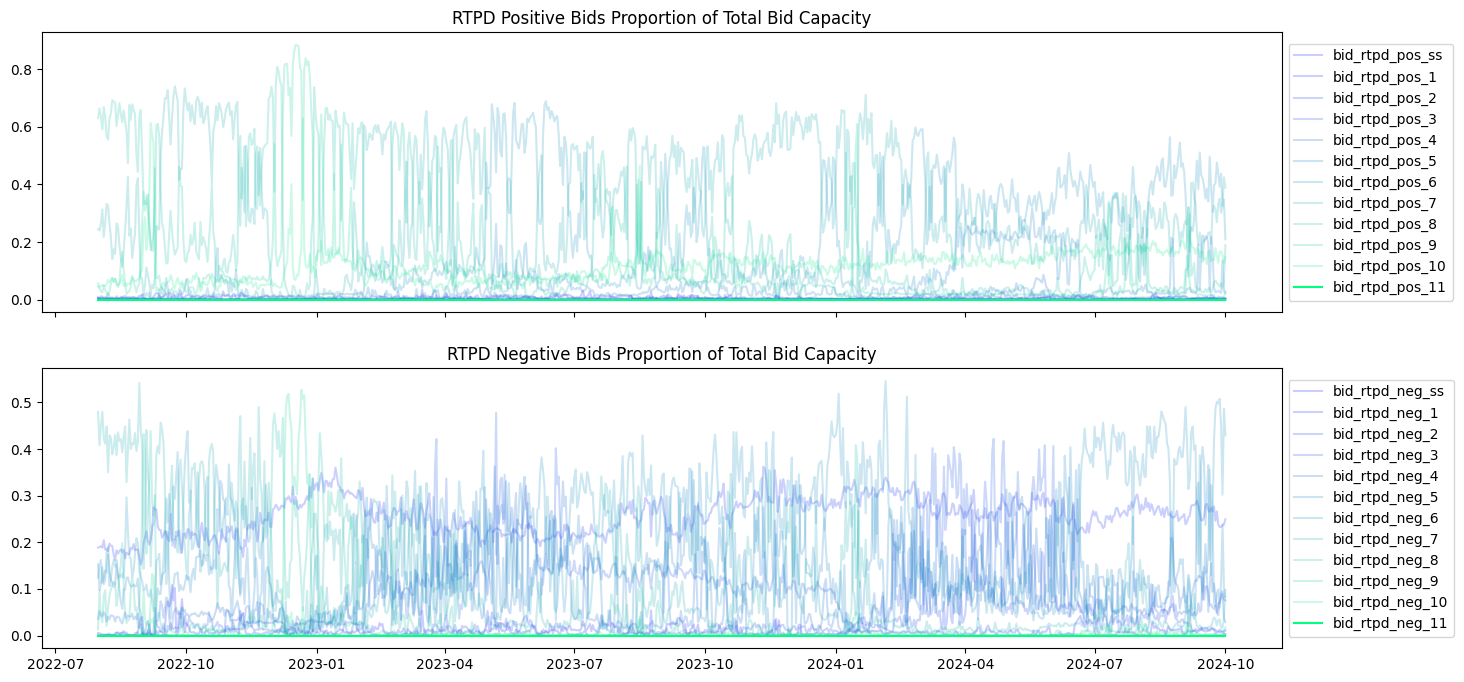

In [18]:
# plot rtpd
fig, axs = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

# set interest segment... all other segments have lower opacities
interest_segment = "11"

# Get the colormap
cmap = plt.get_cmap("winter")
colors = cmap(np.linspace(0, 1, len([col for col in bid_columns if "rtpd_pos" in col])))

# Plot rtpd_pos_x proportions with lowered opacity for non-interest segments
for i, col in enumerate([col for col in bid_columns if "rtpd_pos" in col]):
    if interest_segment in col:
        axs[0].plot(
            df_daily_aggregate.index,
            df_daily_aggregate[col] / df_daily_aggregate["bid_rtpd_pos_tot"],
            label=col,
            color=colors[i],
        )
    else:
        axs[0].plot(
            df_daily_aggregate.index,
            df_daily_aggregate[col] / df_daily_aggregate["bid_rtpd_pos_tot"],
            label=col,
            color=colors[i],
            alpha=0.2,
        )
axs[0].set_title("RTPD Positive Bids Proportion of Total Bid Capacity")

# Plot rtpd_neg_x proportions with lowered opacity for non-interest segments
for i, col in enumerate([col for col in bid_columns if "rtpd_neg" in col]):
    if interest_segment in col:
        axs[1].plot(
            df_daily_aggregate.index,
            df_daily_aggregate[col] / df_daily_aggregate["bid_rtpd_neg_tot"],
            label=col,
            color=colors[i],
        )
    else:
        axs[1].plot(
            df_daily_aggregate.index,
            df_daily_aggregate[col] / df_daily_aggregate["bid_rtpd_neg_tot"],
            label=col,
            color=colors[i],
            alpha=0.2,
        )
axs[1].set_title("RTPD Negative Bids Proportion of Total Bid Capacity")

# Move the legend off the right side of the plot
axs[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
axs[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.show()

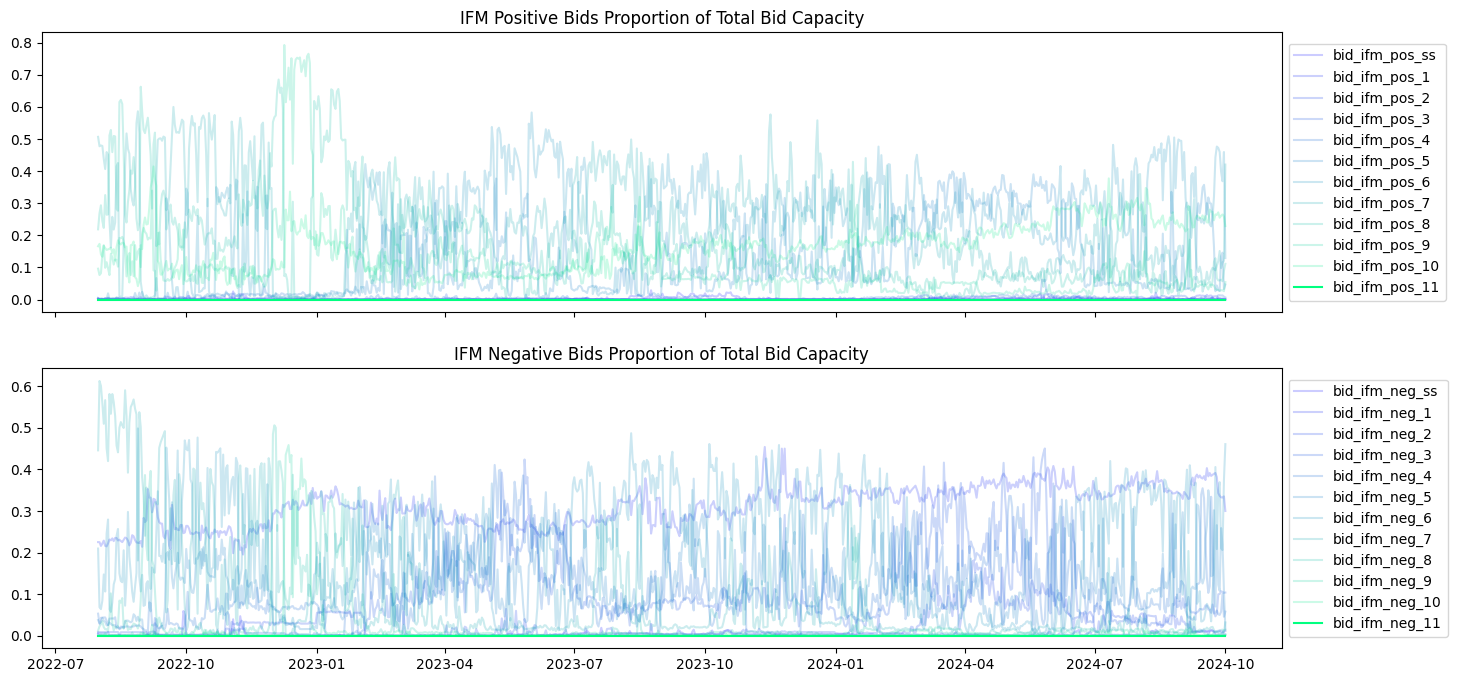

In [19]:
# plot ifm
fig, axs = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

# Plot ifm_pos_x proportions with lowered opacity for non-interest segments
for i, col in enumerate([col for col in bid_columns if "ifm_pos" in col]):
    if interest_segment in col:
        axs[0].plot(
            df_daily_aggregate.index,
            df_daily_aggregate[col] / df_daily_aggregate["bid_ifm_pos_tot"],
            label=col,
            color=colors[i],
        )
    else:
        axs[0].plot(
            df_daily_aggregate.index,
            df_daily_aggregate[col] / df_daily_aggregate["bid_ifm_pos_tot"],
            label=col,
            color=colors[i],
            alpha=0.2,
        )
axs[0].set_title("IFM Positive Bids Proportion of Total Bid Capacity")

# Plot ifm_neg_x proportions with lowered opacity for non-interest segments
for i, col in enumerate([col for col in bid_columns if "ifm_neg" in col]):
    if interest_segment in col:
        axs[1].plot(
            df_daily_aggregate.index,
            df_daily_aggregate[col] / df_daily_aggregate["bid_ifm_neg_tot"],
            label=col,
            color=colors[i],
        )
    else:
        axs[1].plot(
            df_daily_aggregate.index,
            df_daily_aggregate[col] / df_daily_aggregate["bid_ifm_neg_tot"],
            label=col,
            color=colors[i],
            alpha=0.2,
        )
axs[1].set_title("IFM Negative Bids Proportion of Total Bid Capacity")

# Move the legend off the right side of the plot
axs[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
axs[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.show()

ss


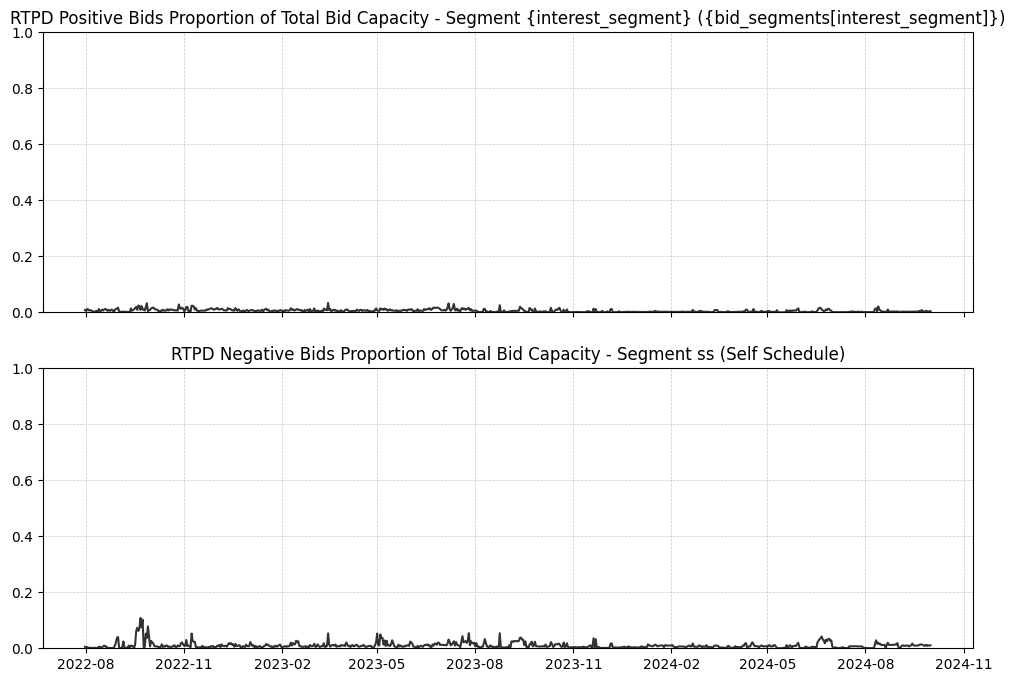

-0.00011355178591170188
1


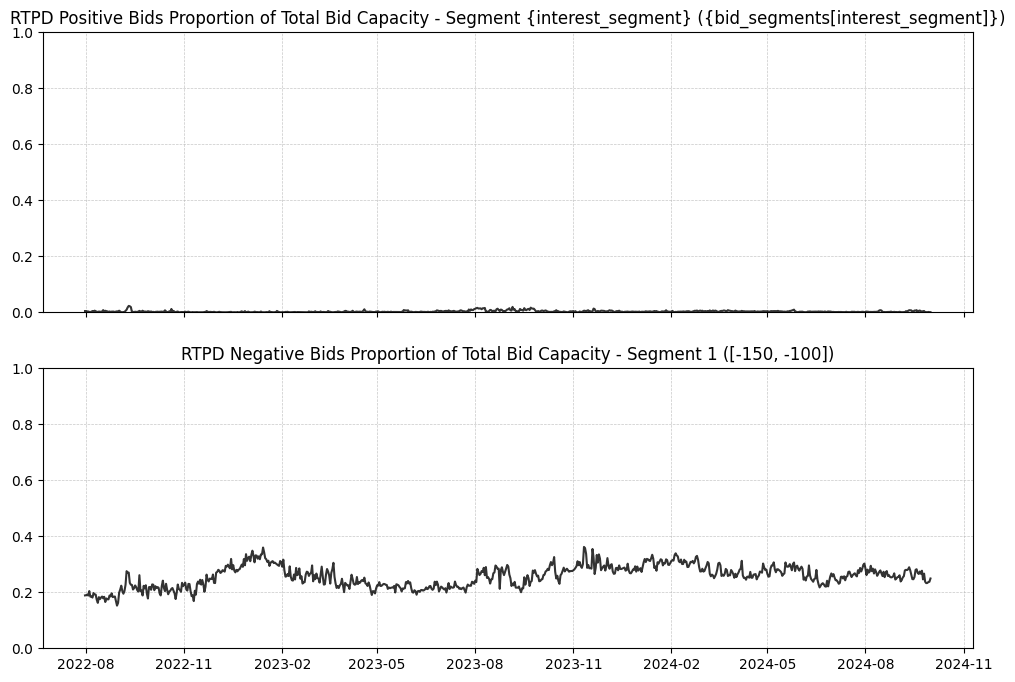

-0.1405205638549434
2


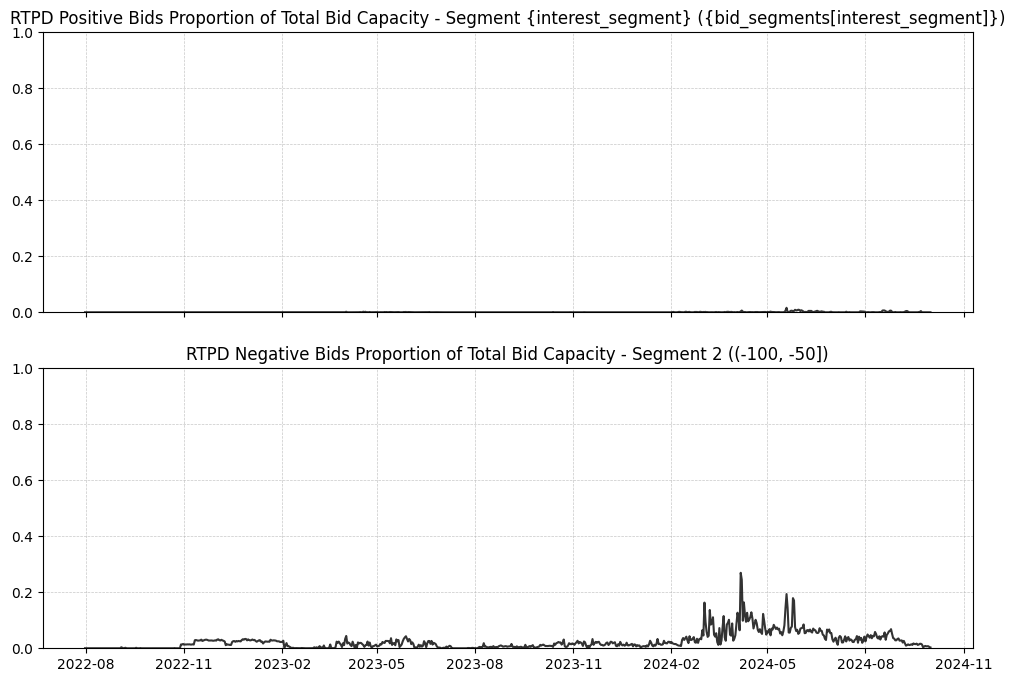

0.0
3


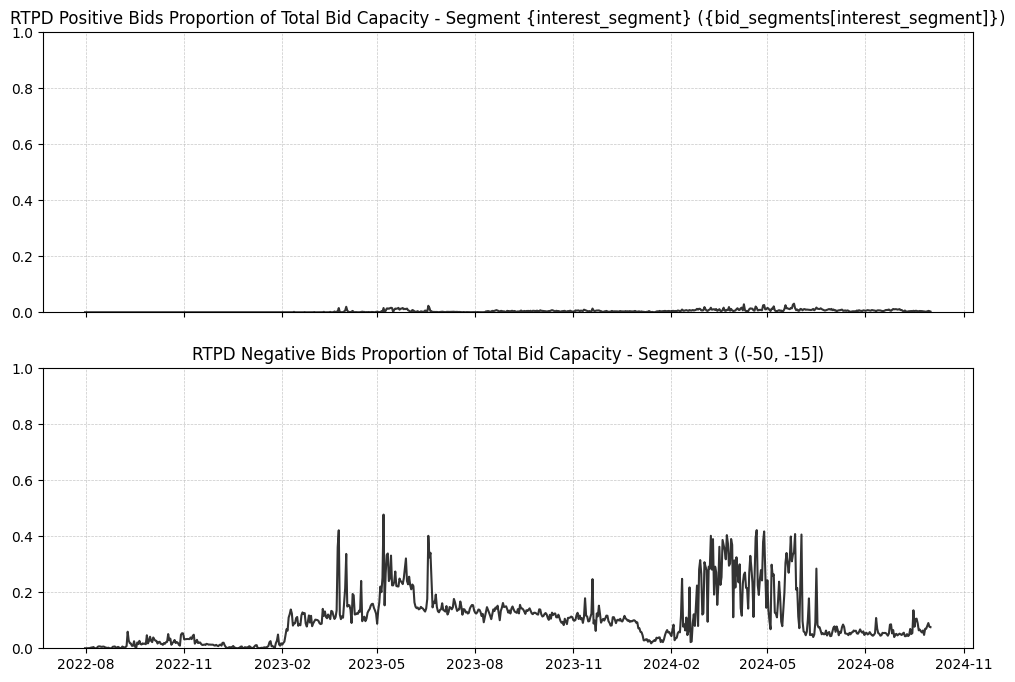

0.0
4


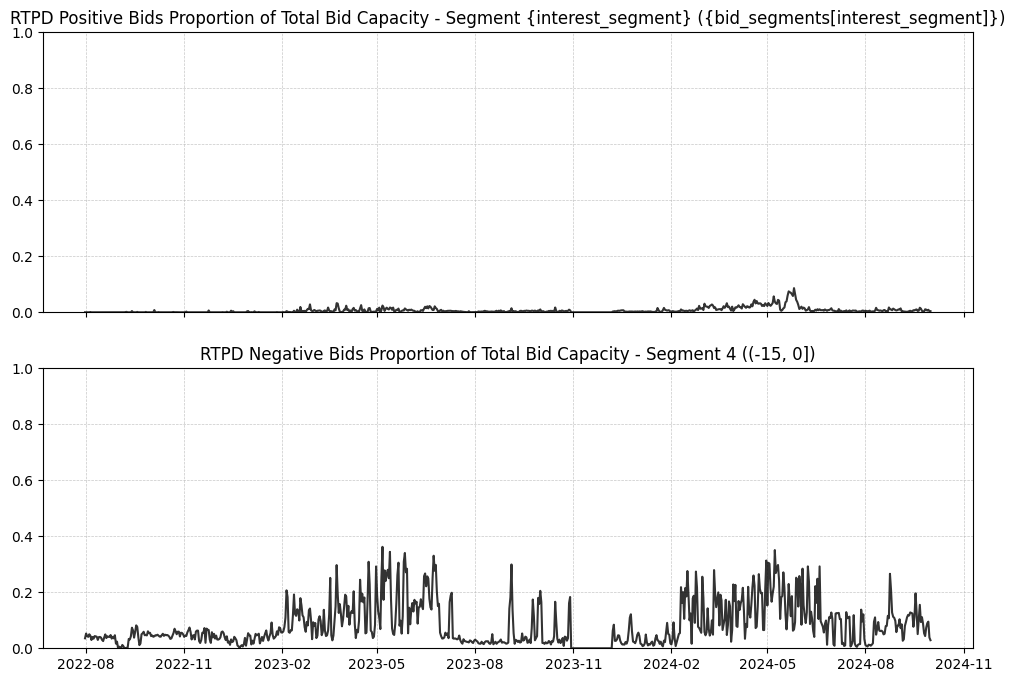

0.0
5


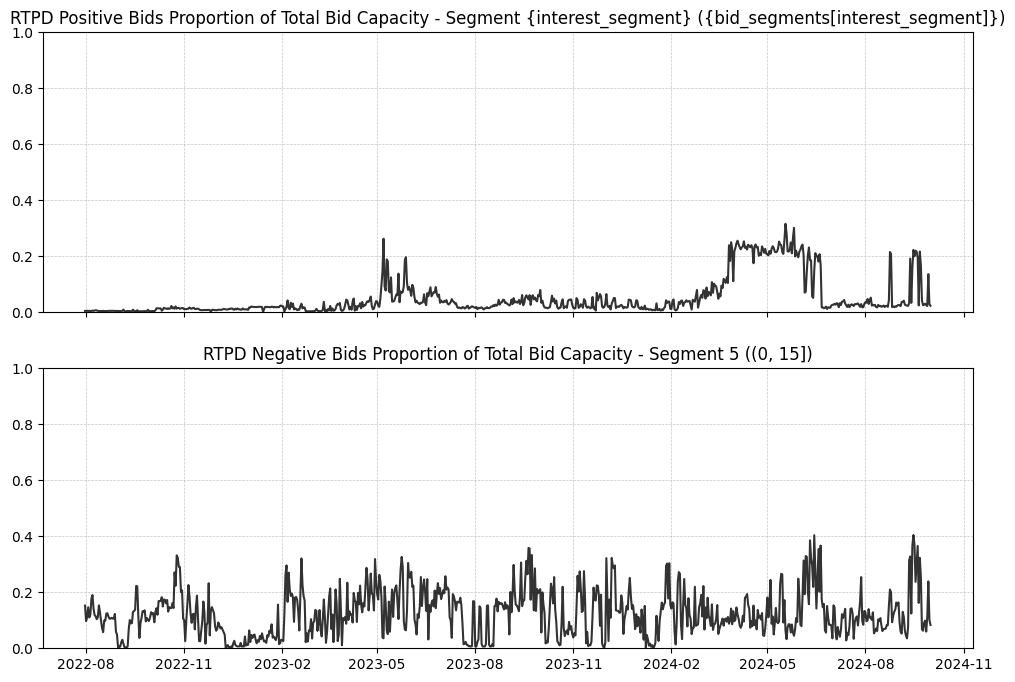

-0.00023496312279750473
6


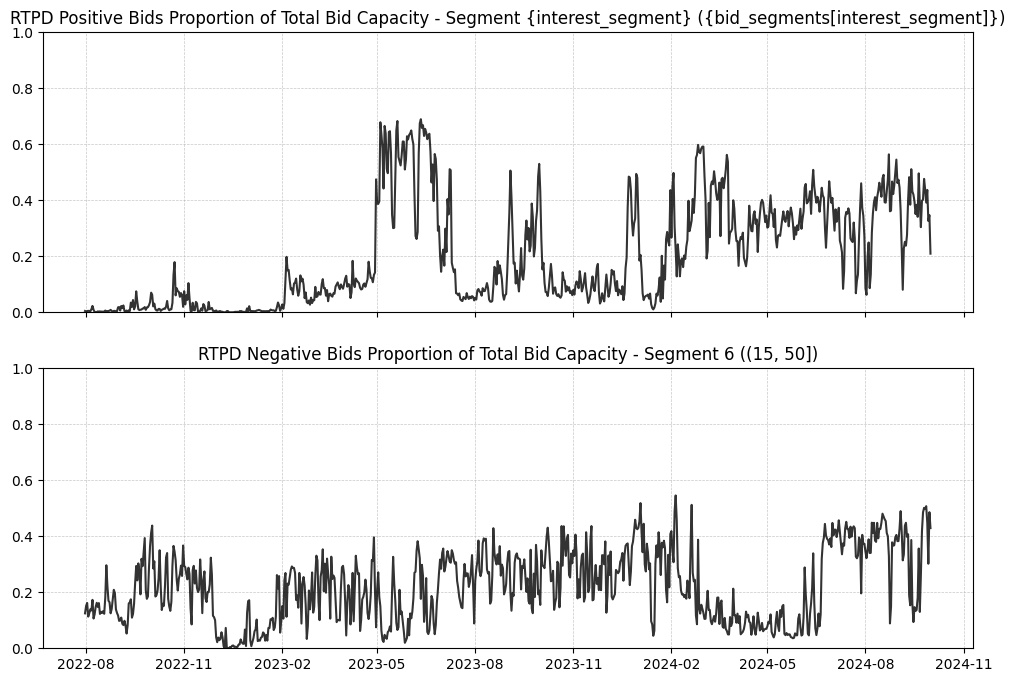

-0.00016383856356761038
7


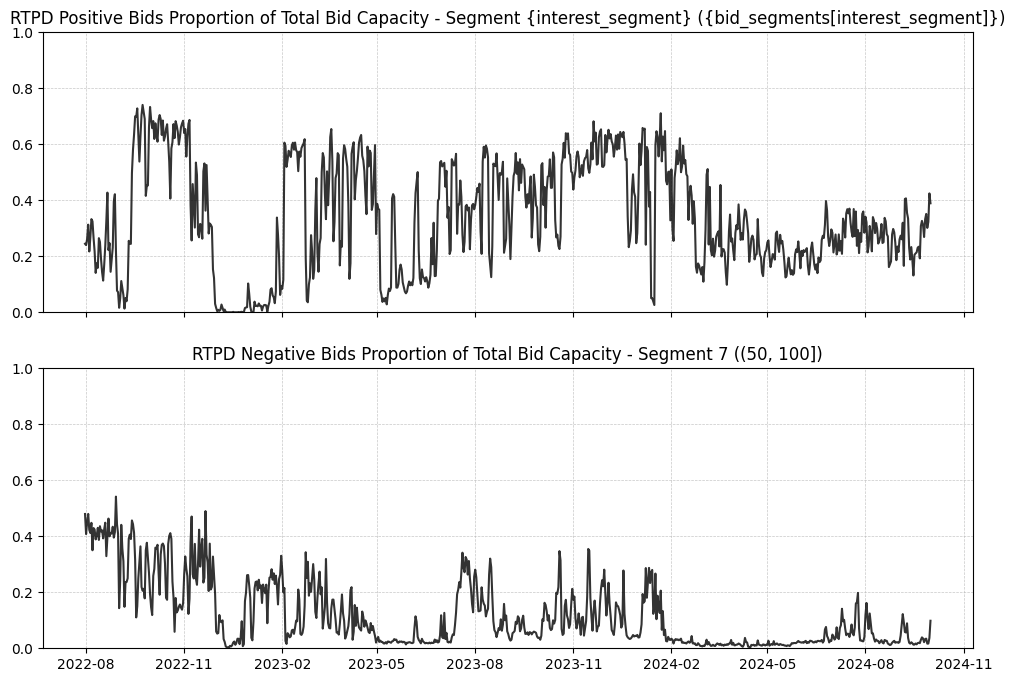

-0.002710089801750762
8


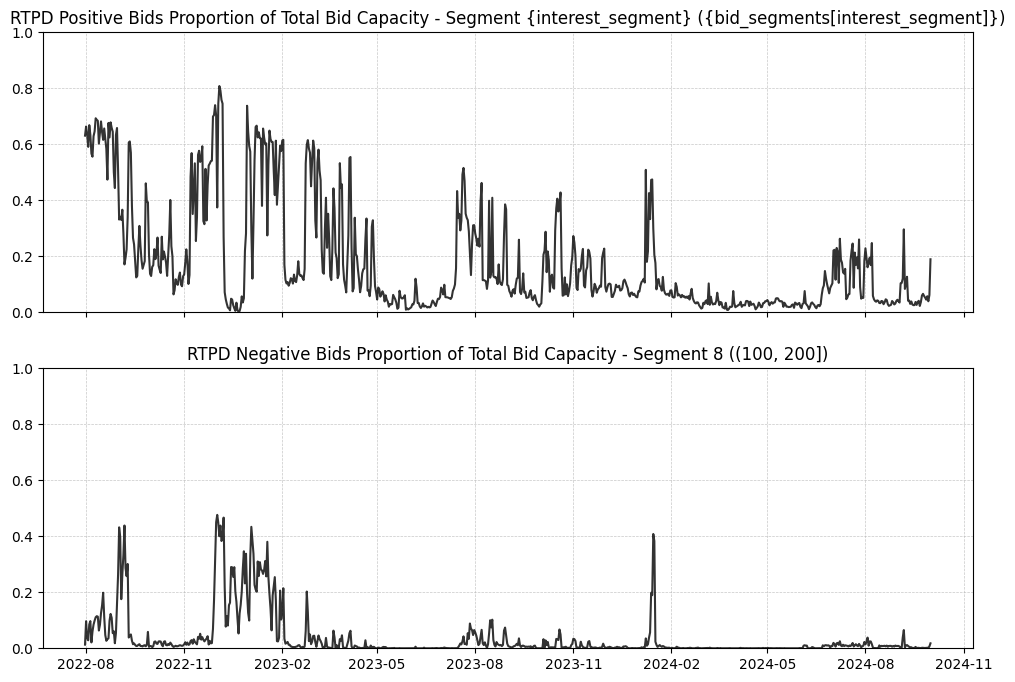

0.0
9


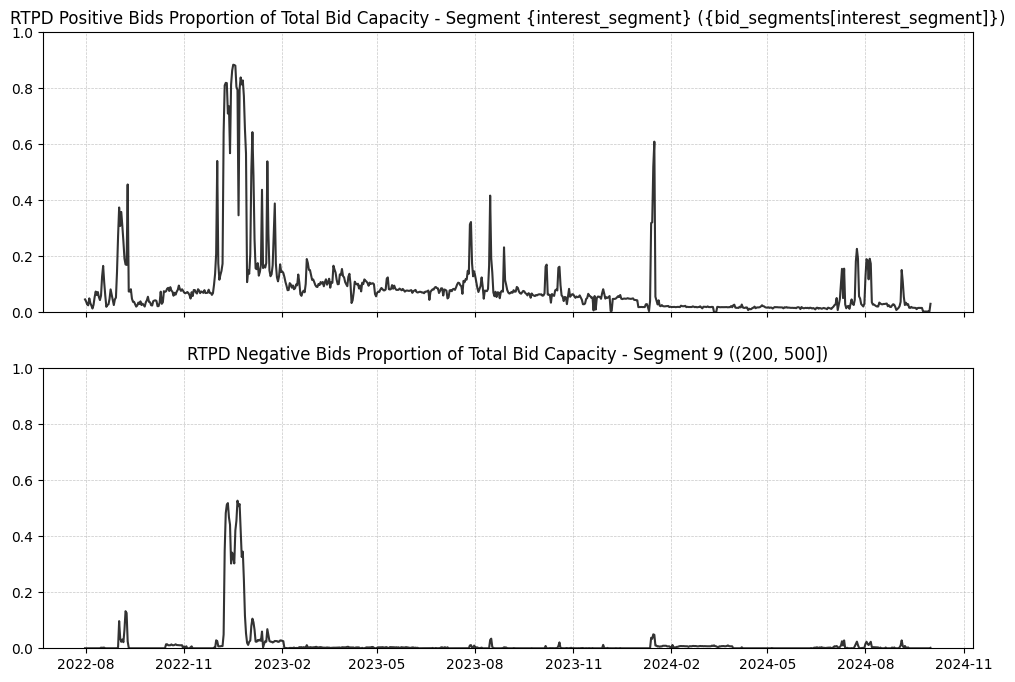

0.0
10


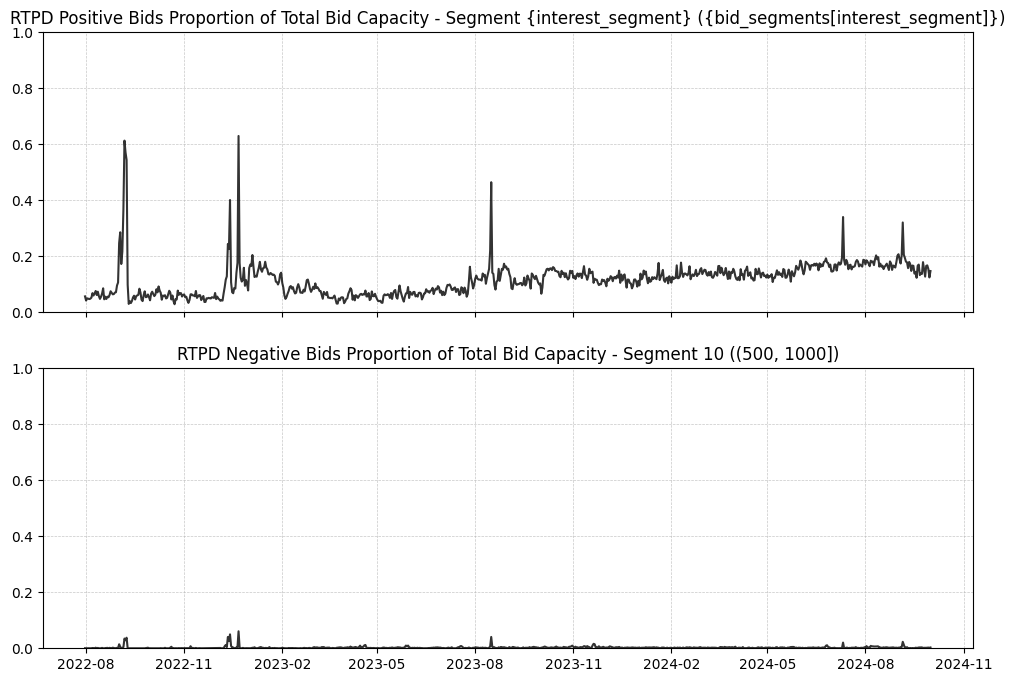

0.0
11


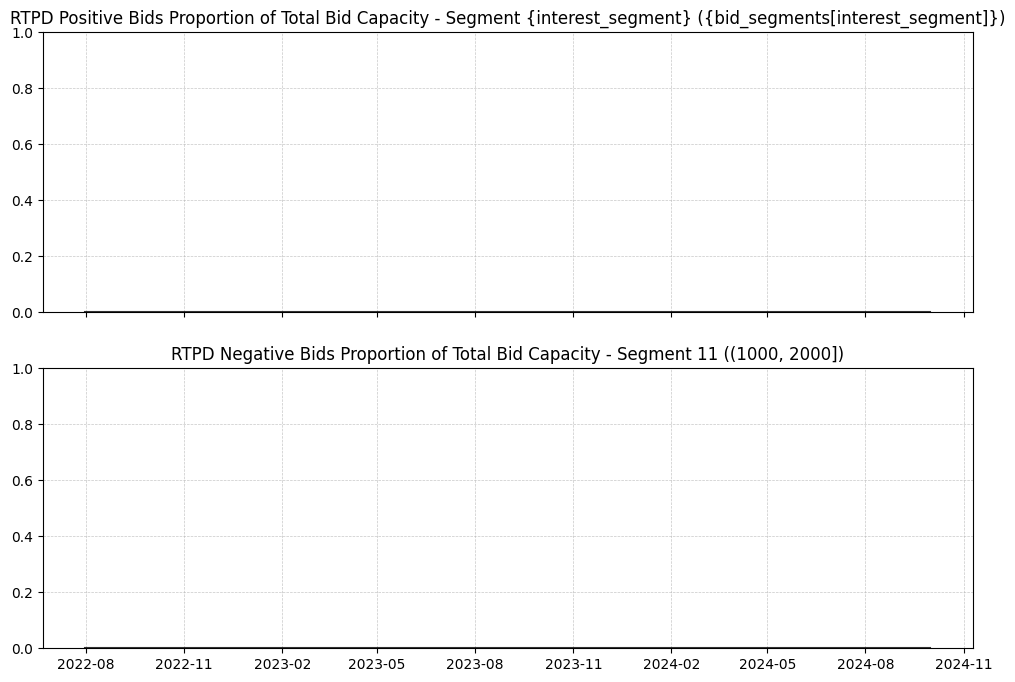

0.0


In [46]:
for interest_segment in ["ss"] + list(str(val + 1) for val in range(11)):
    print(interest_segment)
    # plot rtpd for interest segment
    fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Plot rtpd_pos_x proportions for interest segment
    for i, col in enumerate(
        [
            col
            for col in bid_columns
            if "rtpd_pos" in col and col.endswith("_" + interest_segment)
        ]
    ):
        axs[0].plot(
            df_daily_aggregate.index,
            df_daily_aggregate[col] / df_daily_aggregate["bid_rtpd_pos_tot"],
            label=col,
            color="black",
            alpha=0.8,
        )

    axs[0].set_title(
        "RTPD Positive Bids Proportion of Total Bid Capacity - Segment {interest_segment} ({bid_segments[interest_segment]})"
    )
    axs[0].set_ylim(0, 1)  # Adjust y-axis

    # Plot rtpd_neg_x proportions for interest segment
    for i, col in enumerate(
        [
            col
            for col in bid_columns
            if "rtpd_neg" in col and col.endswith("_" + interest_segment)
        ]
    ):
        axs[1].plot(
            df_daily_aggregate.index,
            df_daily_aggregate[col] / df_daily_aggregate["bid_rtpd_neg_tot"],
            label=col,
            color="black",
            alpha=0.8,
        )
    axs[1].set_title(
        f"RTPD Negative Bids Proportion of Total Bid Capacity - Segment {interest_segment} ({bid_segments[interest_segment]})"
    )
    axs[1].set_ylim(0, 1)  # Adjust y-axis

    # Set grid lines
    for ax in axs:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        ax.yaxis.set_major_locator(MultipleLocator(0.2))
        ax.grid(True)
        # Set grid lines with lower opacity
        for ax in axs:
            ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
    plt.show()
    print(max(df_daily_aggregate[col] / df_daily_aggregate["bid_rtpd_pos_tot"]))

ss


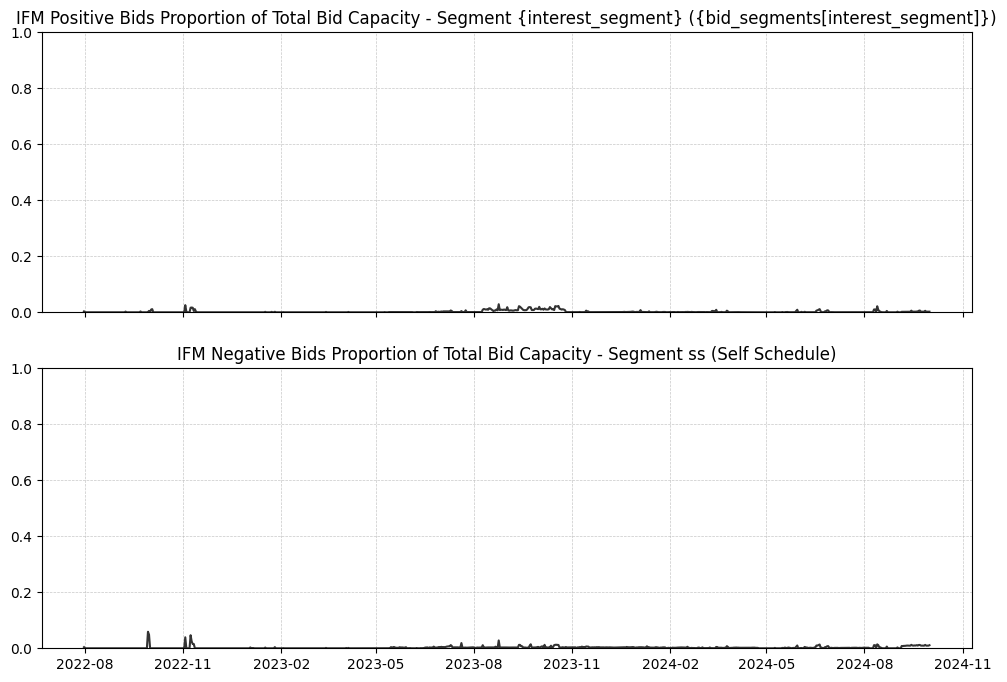

0.0
1


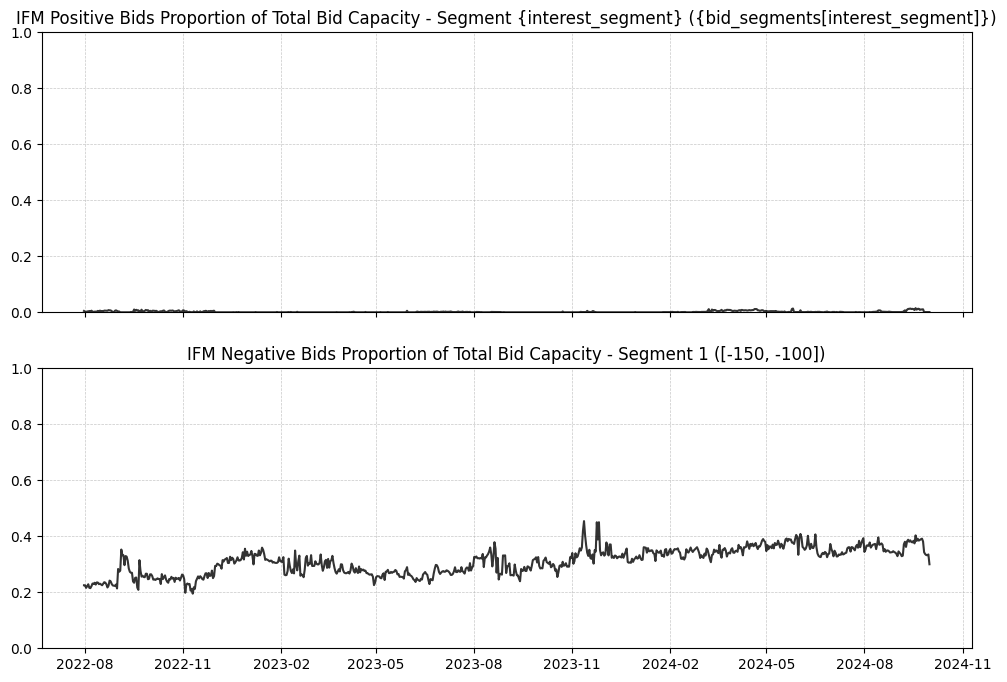

-0.185807462004804
2


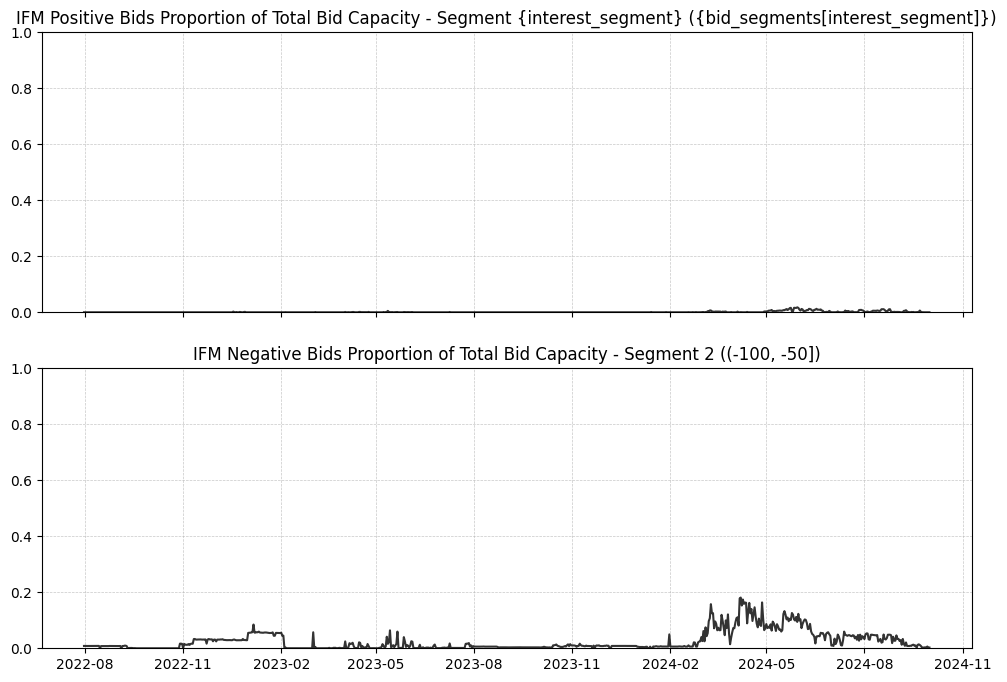

-3.6510762788697904e-06
3


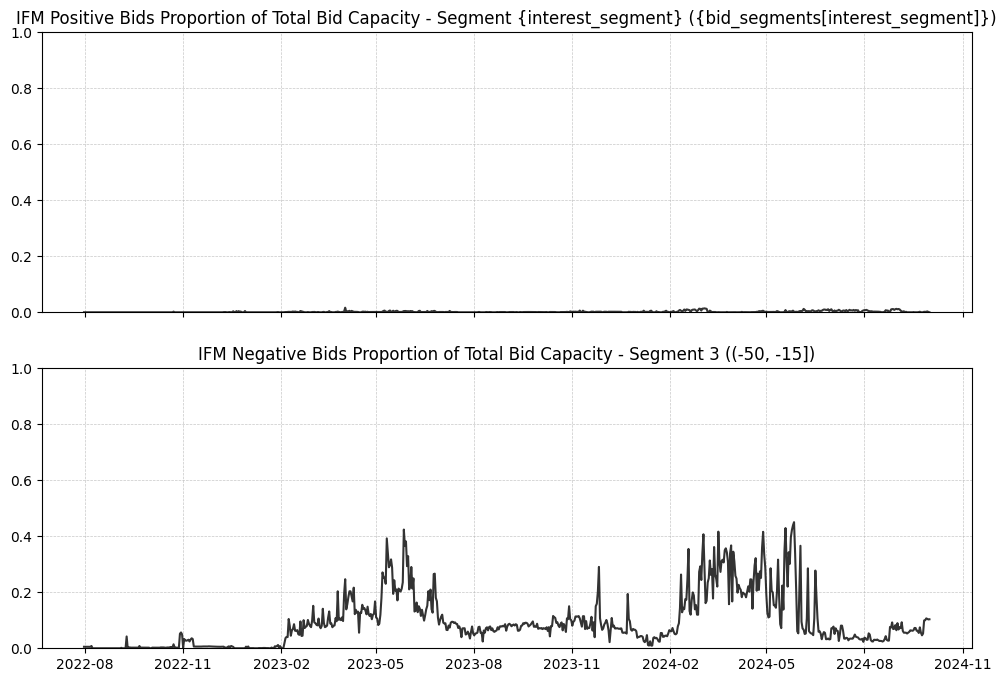

0.0
4


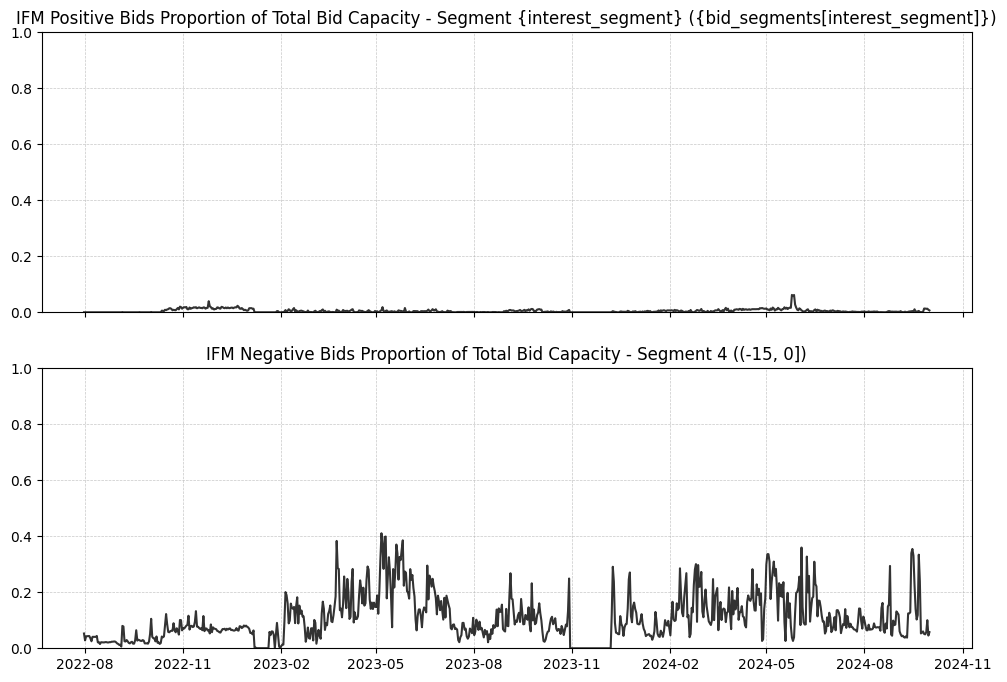

0.0
5


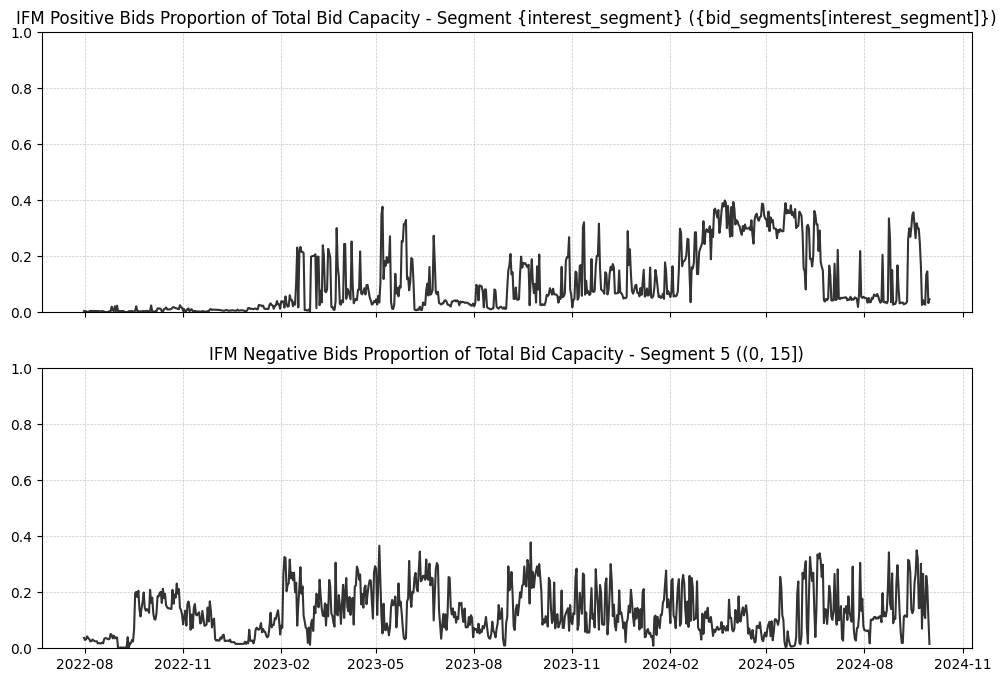

0.0
6


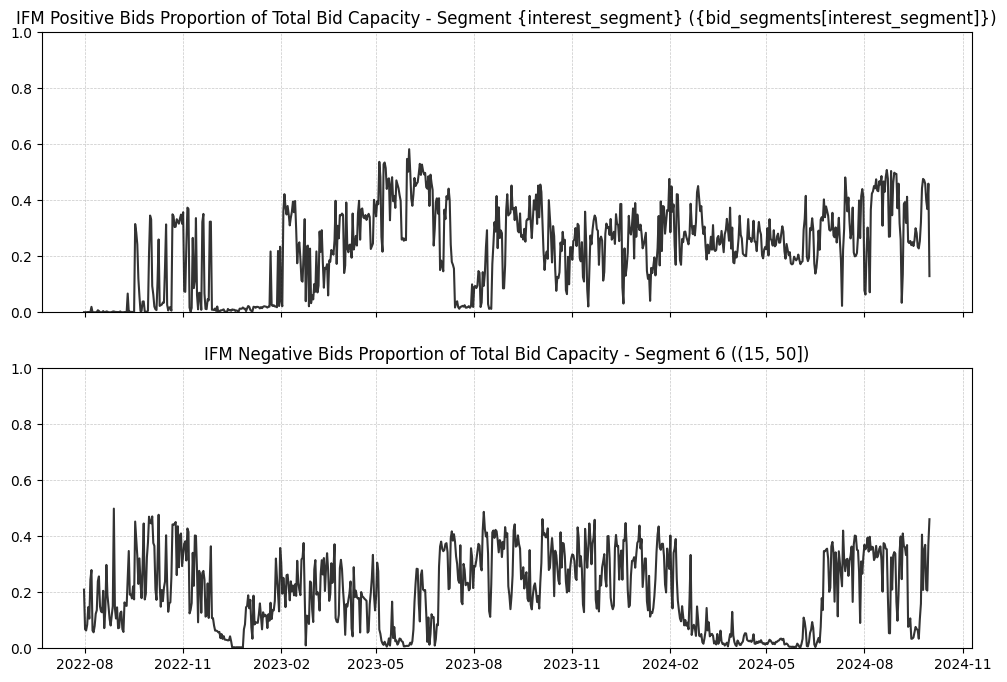

-0.0011755526740509126
7


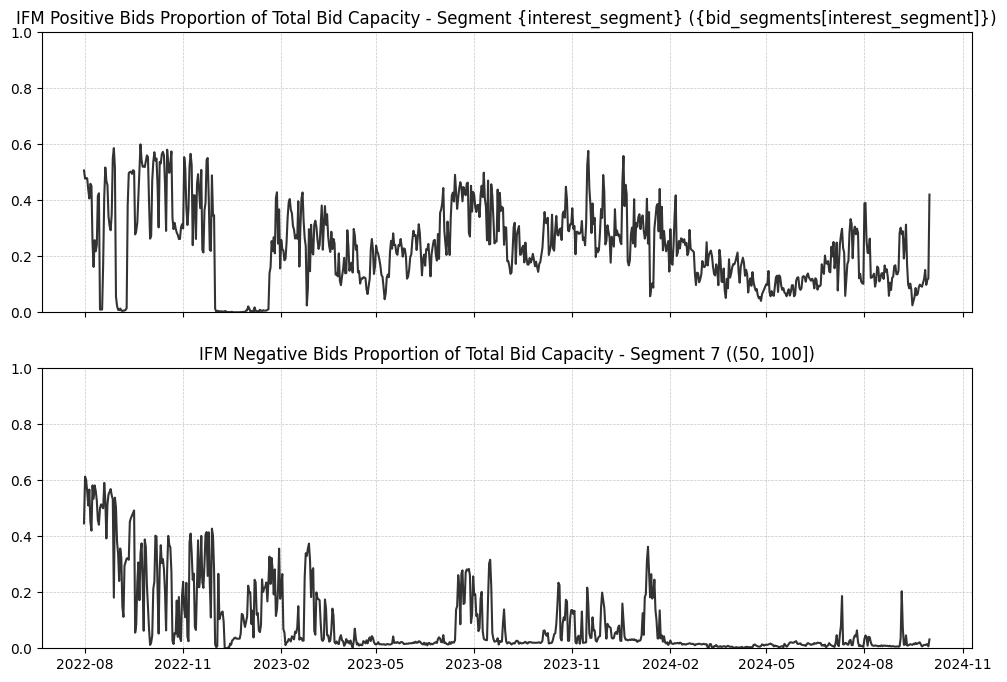

-1.1843867505970491e-05
8


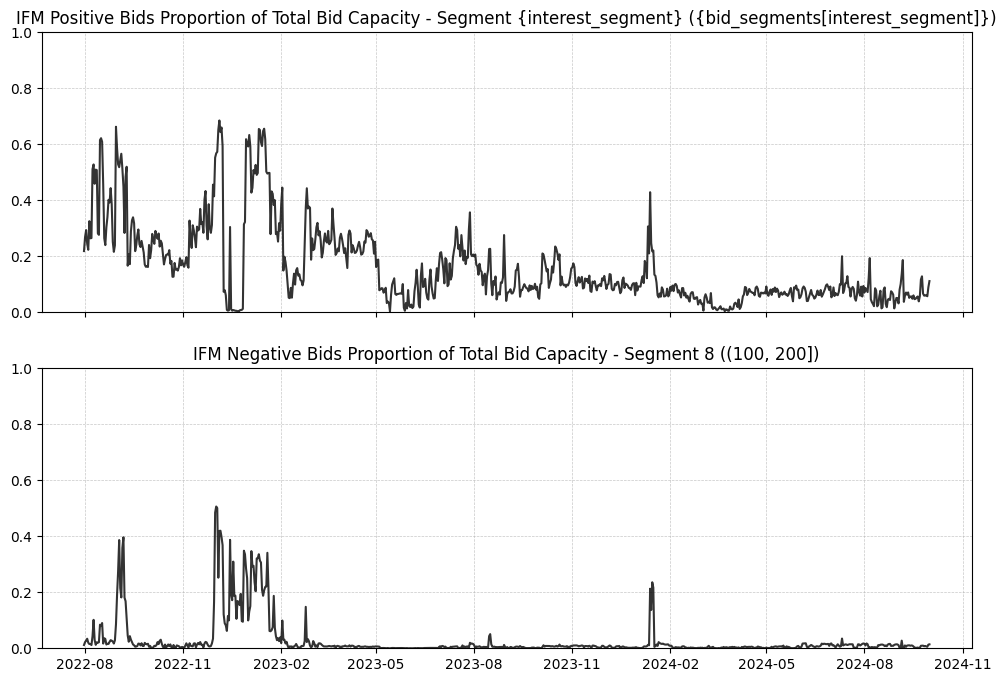

0.0
9


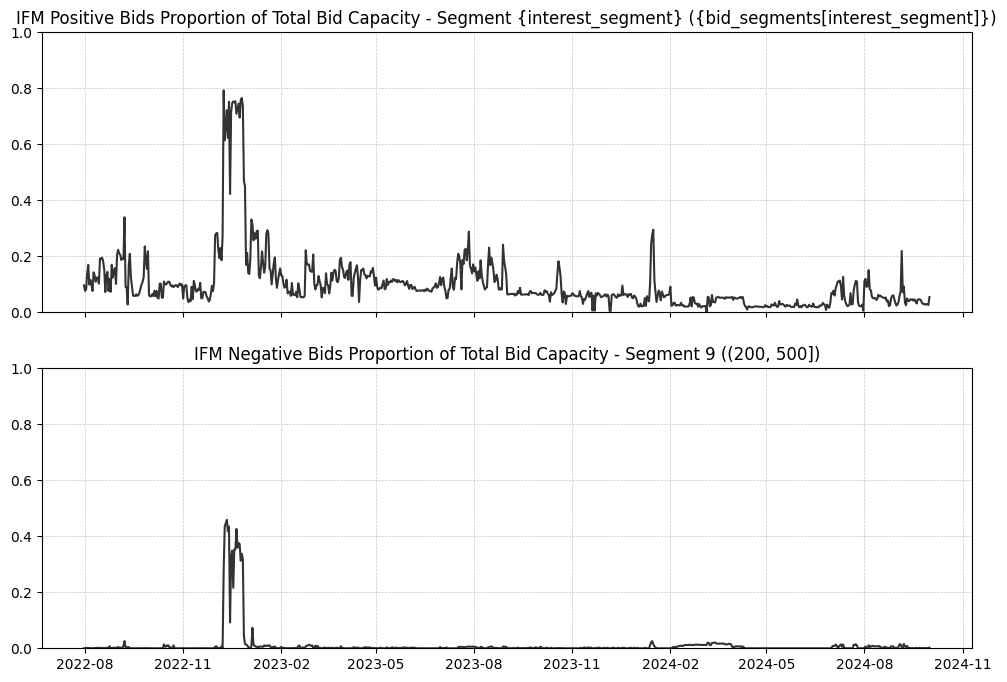

0.0
10


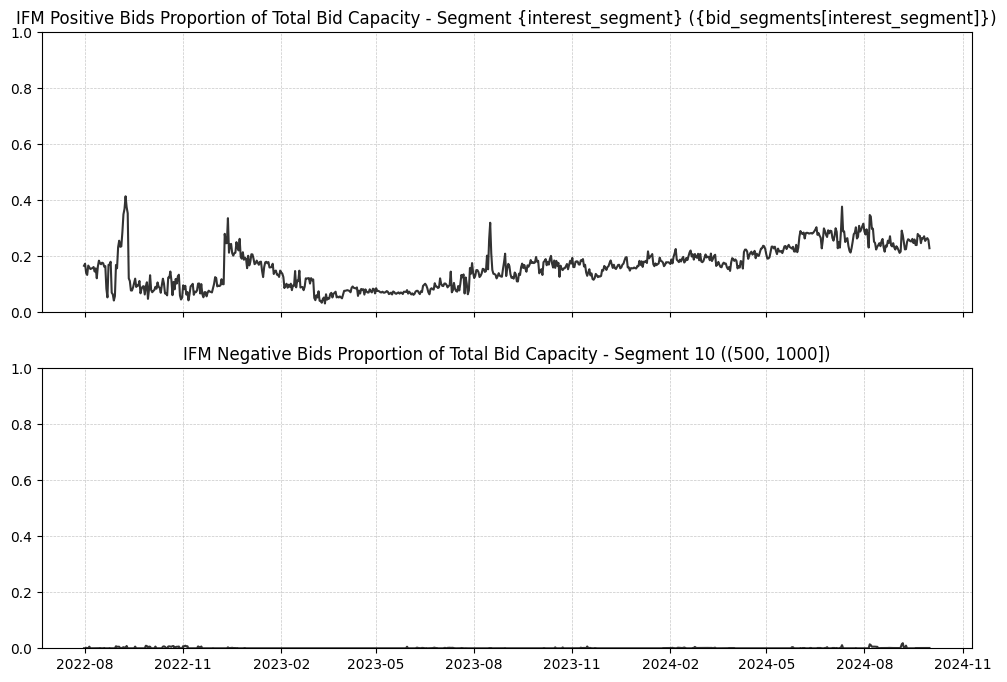

0.0
11


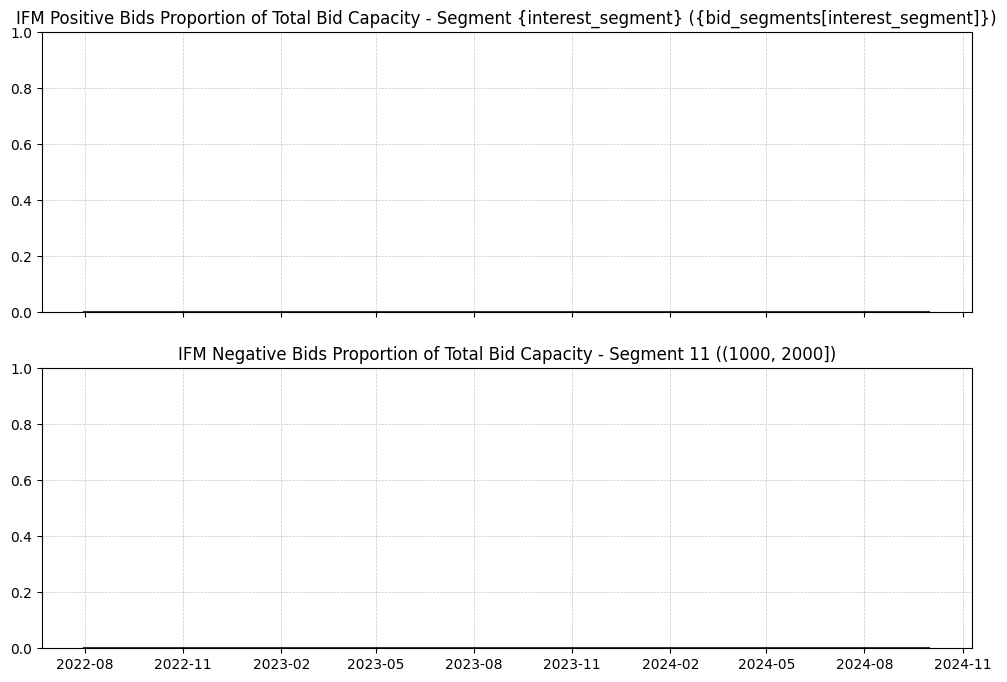

0.0


In [47]:
for interest_segment in ["ss"] + list(str(val + 1) for val in range(11)):
    print(interest_segment)
    # plot ifm for interest segment
    fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Plot ifm_pos_x proportions for interest segment
    for i, col in enumerate(
        [
            col
            for col in bid_columns
            if "ifm_pos" in col and col.endswith("_" + interest_segment)
        ]
    ):
        axs[0].plot(
            df_daily_aggregate.index,
            df_daily_aggregate[col] / df_daily_aggregate["bid_ifm_pos_tot"],
            label=col,
            color="black",
            alpha=0.8,
        )
    axs[0].set_title(
        "IFM Positive Bids Proportion of Total Bid Capacity - Segment {interest_segment} ({bid_segments[interest_segment]})"
    )
    axs[0].set_ylim(0, 1)  # Adjust y-axis

    # Plot ifm_neg_x proportions for interest segment
    for i, col in enumerate(
        [
            col
            for col in bid_columns
            if "ifm_neg" in col and col.endswith("_" + interest_segment)
        ]
    ):
        axs[1].plot(
            df_daily_aggregate.index,
            df_daily_aggregate[col] / df_daily_aggregate["bid_ifm_neg_tot"],
            label=col,
            color="black",
            alpha=0.8,
        )
    axs[1].set_title(
        f"IFM Negative Bids Proportion of Total Bid Capacity - Segment {interest_segment} ({bid_segments[interest_segment]})"
    )
    axs[1].set_ylim(0, 1)  # Adjust y-axis

    # Set grid lines
    for ax in axs:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        ax.yaxis.set_major_locator(MultipleLocator(0.2))
        ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

    plt.show()
    print(max(df_daily_aggregate[col] / df_daily_aggregate["bid_ifm_pos_tot"]))

In [31]:
# Filter columns containing '11'
bid_11_columns = [col for col in df.columns if "11" in col]

# Calculate the sum for each of these columns
bid_11_sums = df[bid_11_columns].sum()

# Print the sums
print(bid_11_sums)

key
bid_ifm_pos_11     0.0
bid_ifm_neg_11     0.0
bid_rtpd_pos_11    0.0
bid_rtpd_neg_11    0.0
dtype: float64


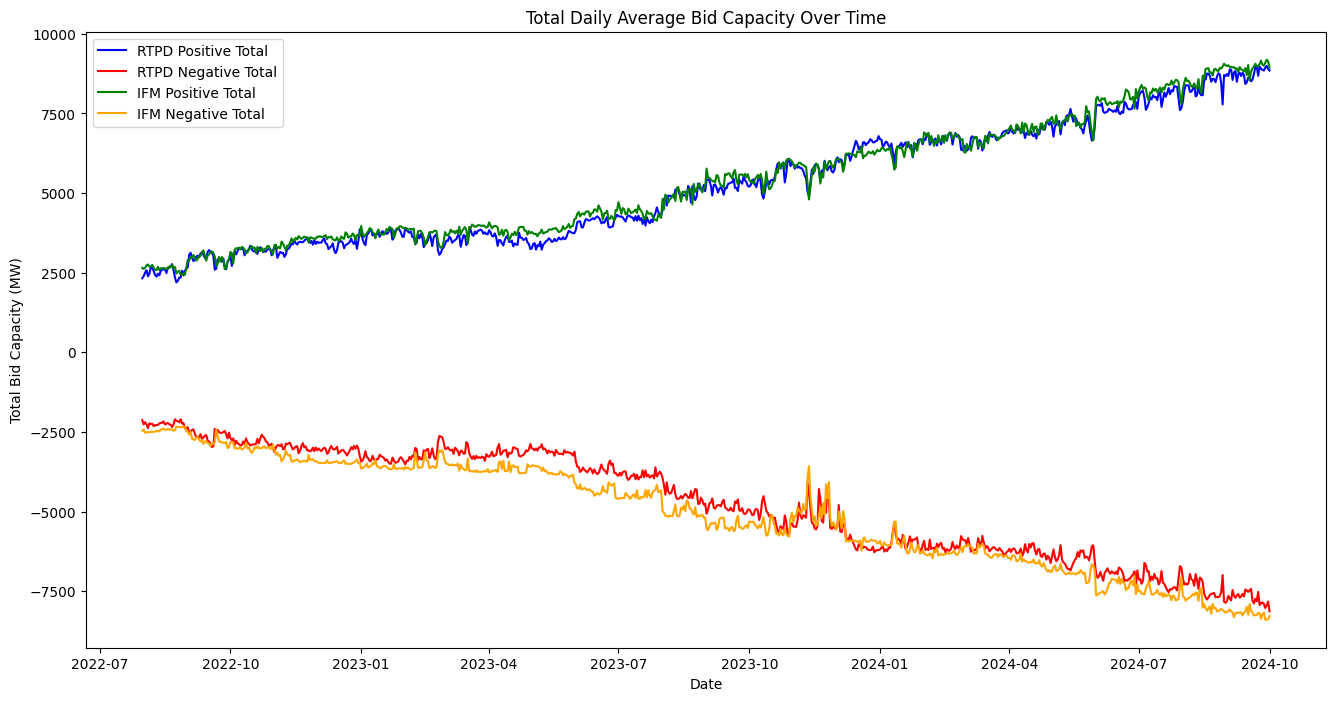

In [22]:
# Plot total bid capacity over time for both positive and negative RTPD and IFM bids
fig, ax = plt.subplots(figsize=(16, 8))

# Plot RTPD positive and negative total bid capacity
ax.plot(
    df_daily_aggregate.index,
    df_daily_aggregate["bid_rtpd_pos_tot"],
    label="RTPD Positive Total",
    color="blue",
)
ax.plot(
    df_daily_aggregate.index,
    df_daily_aggregate["bid_rtpd_neg_tot"],
    label="RTPD Negative Total",
    color="red",
)

# Plot IFM positive and negative total bid capacity
ax.plot(
    df_daily_aggregate.index,
    df_daily_aggregate["bid_ifm_pos_tot"],
    label="IFM Positive Total",
    color="green",
)
ax.plot(
    df_daily_aggregate.index,
    df_daily_aggregate["bid_ifm_neg_tot"],
    label="IFM Negative Total",
    color="orange",
)

# Set title and labels
ax.set_title("Total Daily Average Bid Capacity Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Total Bid Capacity (MW)")

# Add legend
ax.legend(loc="upper left")

plt.show()

In [23]:
print(
    df_daily_aggregate["bid_ifm_pos_tot"][0], df_daily_aggregate["bid_ifm_pos_tot"][-1]
)

2652.240416666667 8935.8875


C:\Users\Astro\AppData\Local\Temp\ipykernel_29960\1428866444.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(df_daily_aggregate["bid_ifm_pos_tot"][0], df_daily_aggregate["bid_ifm_pos_tot"][-1])
